In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from itertools import islice
import numpy as np
from skimage.external import tifffile
from skimage.external.tifffile import imread
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random
from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor
from scipy import ndimage
from PIL import Image, ImageDraw
import numpy.ma as ma
from skimage.measure import label, regionprops

In [2]:
import seaborn as sns

## Pixel Distribution of HP1 (HP1B) and DAPI signal
- Select random 10 cells from the chosen dataset
- calculate HP1 (HP1B) signal and DAPI signal for each pixel of the image
- plot HP1 signal vs DAPI signal for each cell 
- look for any pattern noticed - ex) normal linear relationship, grouping in the plots, etc

In [3]:
bigDir=r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading'

In [4]:
newfile=f'{bigDir}\\new dataset\signals_new_v5.csv'

In [5]:
newdata=pd.read_csv(newfile)

In [6]:
newdata=newdata.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [7]:
newdata.head()

file original cell name                       movie  \
0  20191203_cell-00.czi     20191125-01-17  191125pcnat_dhbr_cdc6vxy01   
1  20191203_cell-01.czi     20191125-01-20  191125pcnat_dhbr_cdc6vxy01   
2  20191203_cell-02.czi     20191125-01-23  191125pcnat_dhbr_cdc6vxy01   
3  20191203_cell-03.czi     20191125-01-25  191125pcnat_dhbr_cdc6vxy01   
4  20191203_cell-04.czi     20191125-01-32  191125pcnat_dhbr_cdc6vxy01   

   last frame movie position x  last frame movie position y ab1 (MCM)  ab1 ch  \
0                      678.301                      200.931      MCM3       1   
1                     1552.152                      240.479      MCM3       1   
2                     1131.436                      318.530      MCM3       1   
3                     1650.585                      324.968      MCM3       1   
4                     1466.687                      426.815      MCM3       1   

  ab2 (heterochromatin)  ab2 ch  DAPI ch  ...  mol_age_mod nuc_hp1b_total  \
0               HP1beta       2        3  ...        0.444   1.415176e+09   
1               HP1beta       2        3  ...        1.373   2.175016e+09   
2               HP1beta       2        3  ...        1.371   1.933001e+09   
3               HP1beta       2        3  ...        0.208   1.062142e+09   
4               HP1beta       2        3  ...        0.345   1.717888e+09   

   inner_hp1b_total  outer_hp1b_total nuc_hp1b_het  inner_hp1b_het  \
0       425500564.0      9.896759e+08  550518042.0     321679433.0   
1       804184935.0      1.370831e+09  896267478.0     567124747.0   
2       666820604.0      1.266180e+09  732487366.0     444813519.0   
3       233589820.0      8.285525e+08  403943621.0     187675893.0   
4       546330833.0      1.171557e+09  697150763.0     424718652.0   

  outer_hp1b_het   nuc_hp1b_eu inner_hp1b_eu  outer_hp1b_eu  
0    228838609.0  8.646584e+08   103821131.0   7.608373e+08  
1    329142731.0  1.278748e+09   237060188.0   1.041688e+09  
2    287673847.0  1.200514e+09   222007085.0   9.785064e+08  
3    216267728.0  6.581987e+08    45913927.0   6.122848e+08  
4    272432111.0  1.020738e+09   121612181.0   8.991254e+08  

[5 rows x 59 columns]

### taking a sample of n=10 from the new dataset that is not deconvolized

In [8]:
sample=newdata.loc[(newdata.decon==False),:]

In [9]:
sample=sample.loc[(['G1' in x for x in sample.category]), :].sample(n=10, random_state=107)

In [10]:
sample

file original cell name                       movie  \
102  20191203_cell-130.czi    20191125-08-101  191125pcnat_dhbr_cdc6vxy08   
3     20191203_cell-03.czi     20191125-01-25  191125pcnat_dhbr_cdc6vxy01   
108  20191203_cell-137.czi     20191125-11-82  191125pcnat_dhbr_cdc6vxy11   
58    20191203_cell-78.czi     20191125-05-44  191125pcnat_dhbr_cdc6vxy05   
49    20191203_cell-64.czi    20191125-10-142  191125pcnat_dhbr_cdc6vxy10   
67    20191203_cell-87.czi     20191125-05-88  191125pcnat_dhbr_cdc6vxy05   
81   20191203_cell-103.czi     20191125-07-55  191125pcnat_dhbr_cdc6vxy07   
60    20191203_cell-80.czi     20191125-05-56  191125pcnat_dhbr_cdc6vxy05   
95   20191203_cell-123.czi    20191125-07-125  191125pcnat_dhbr_cdc6vxy07   
5     20191203_cell-05.czi     20191125-01-36  191125pcnat_dhbr_cdc6vxy01   

     last frame movie position x  last frame movie position y ab1 (MCM)  \
102                     1237.094                     1258.126      MCM3   
3                       1650.585                      324.968      MCM3   
108                      916.914                      921.865      MCM3   
58                       947.721                      652.410      MCM3   
49                       520.447                     1594.921      MCM3   
67                       301.901                     1450.886      MCM3   
81                       598.905                      812.930      MCM3   
60                       467.635                      889.574      MCM3   
95                      1258.357                     1764.788      MCM3   
5                       1705.099                      468.246      MCM3   

     ab1 ch ab2 (heterochromatin)  ab2 ch  DAPI ch  ...  mol_age_mod  \
102       1               HP1beta       2        3  ...        0.721   
3         1               HP1beta       2        3  ...        0.208   
108       1               HP1beta       2        3  ...        0.701   
58        1               HP1beta       2        3  ...        0.422   
49        1               HP1beta       2        3  ...        1.009   
67        1               HP1beta       2        3  ...        0.208   
81        1               HP1beta       2        3  ...        0.462   
60        1               HP1beta       2        3  ...        0.674   
95        1               HP1beta       2        3  ...        0.649   
5         1               HP1beta       2        3  ...        0.632   

    nuc_hp1b_total  inner_hp1b_total  outer_hp1b_total nuc_hp1b_het  \
102   1.285848e+09       390107622.0      8.957405e+08  487715875.0   
3     1.062142e+09       233589820.0      8.285525e+08  403943621.0   
108   1.340251e+09       442330664.0      8.979200e+08  509021593.0   
58    1.216596e+09       363577325.0      8.530182e+08  456375018.0   
49    1.448302e+09       408907699.0      1.039394e+09  561312449.0   
67    1.173185e+09       255938367.0      9.172463e+08  438885958.0   
81    1.039684e+09       208705380.0      8.309790e+08  384549104.0   
60    1.373778e+09       453944387.0      9.198338e+08  519606383.0   
95    1.204104e+09       355183847.0      8.489197e+08  434319799.0   
5     1.615431e+09       530009467.0      1.085421e+09  699466569.0   

     inner_hp1b_het outer_hp1b_het  nuc_hp1b_eu inner_hp1b_eu  outer_hp1b_eu  
102     290984487.0    196731388.0  798132293.0    99123135.0    699009158.0  
3       187675893.0    216267728.0  658198734.0    45913927.0    612284807.0  
108     325983023.0    183038570.0  831229094.0   116347641.0    714881453.0  
58      263518999.0    192856019.0  760220527.0   100058326.0    660162201.0  
49      288467325.0    272845124.0  886989714.0   120440374.0    766549340.0  
67      196474325.0    242411633.0  734298719.0    59464042.0    674834677.0  
81      167188893.0    217360211.0  655135258.0    41516487.0    613618771.0  
60      326294309.0    193312074.0  854171789.0   127650078.0    726521711.0  
95      257178787.0    177141012.0  769783719.0    98005060.0 

## #1

20191203_cell-130.czi
shape of the cell image:  (29, 3, 380, 380)
shape of nucleus mask:  (29, 380, 380)


<IPython.core.display.Javascript object>


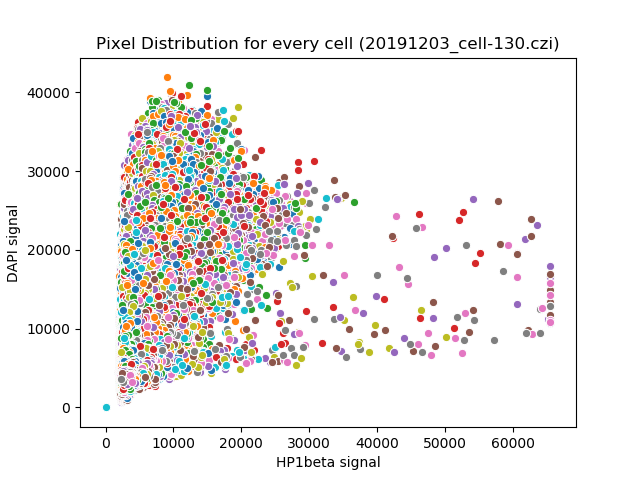

29 380 380
29 380 380


<IPython.core.display.Javascript object>


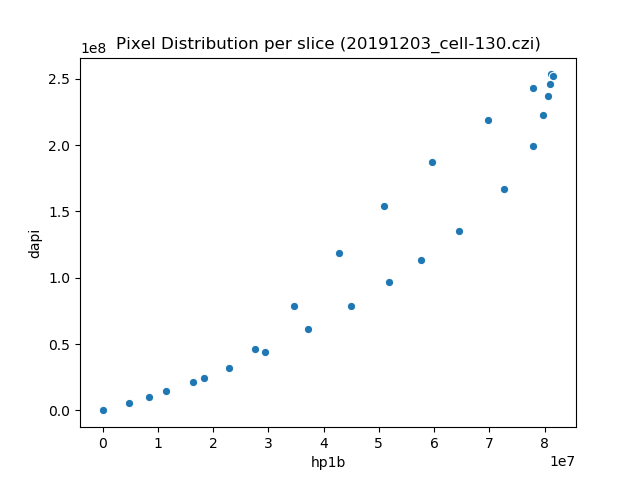

<IPython.core.display.Javascript object>


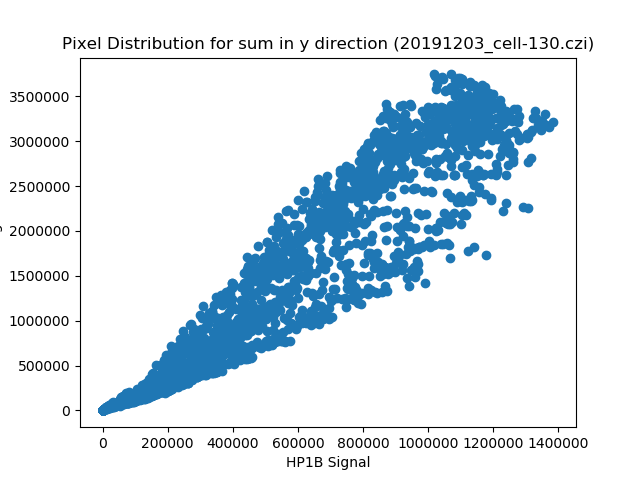

<IPython.core.display.Javascript object>


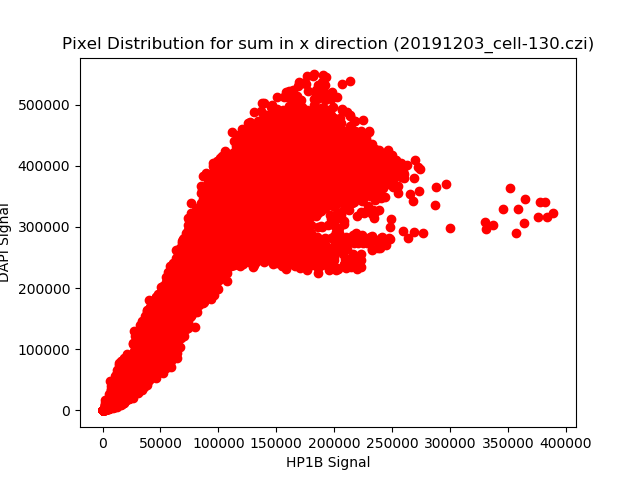

In [17]:
i=0
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
print(slides, xs, ys)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


slides, xs, ys = (hp1.shape)
print(slides, xs, ys)
figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()



## #2 

20191203_cell-03.czi
shape of the cell image:  (37, 3, 380, 380)
shape of nucleus mask:  (37, 380, 380)


<IPython.core.display.Javascript object>


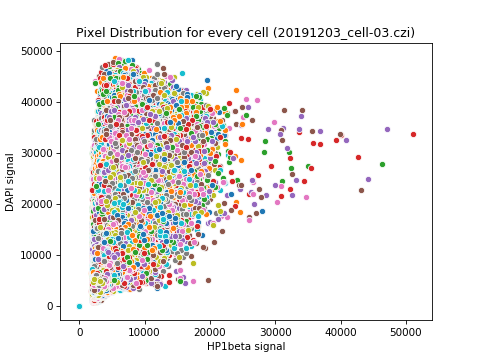

<IPython.core.display.Javascript object>


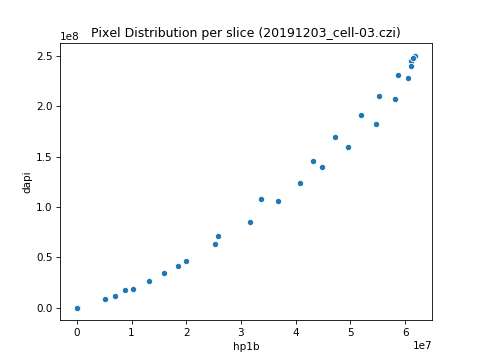

<IPython.core.display.Javascript object>


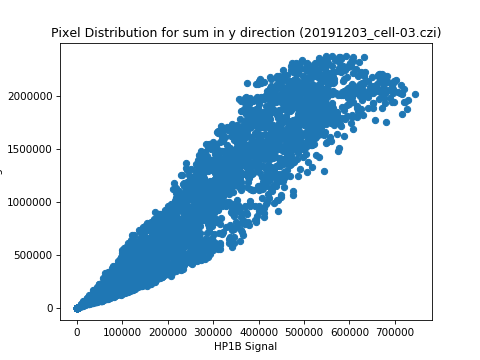

<IPython.core.display.Javascript object>


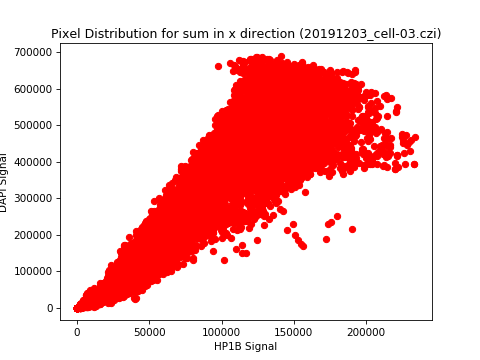

In [18]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


slides, xs, ys = (hp1.shape)
figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #3

20191203_cell-137.czi
shape of the cell image:  (31, 3, 380, 380)
shape of nucleus mask:  (31, 380, 380)


<IPython.core.display.Javascript object>


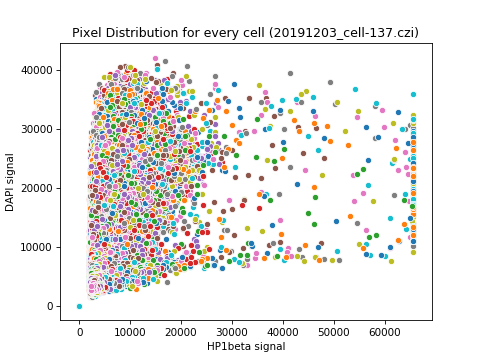

<IPython.core.display.Javascript object>


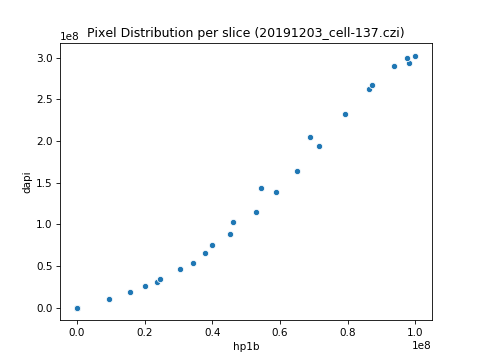

<IPython.core.display.Javascript object>


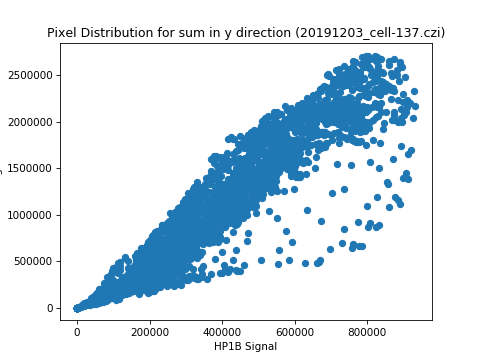

<IPython.core.display.Javascript object>


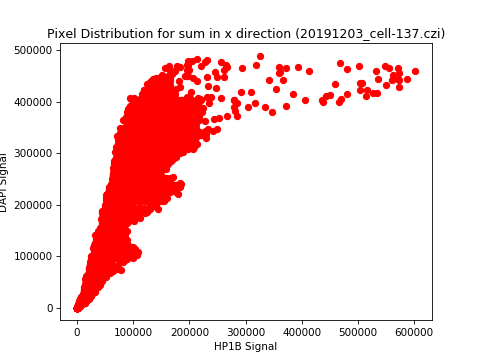

In [19]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #4

20191203_cell-78.czi
shape of the cell image:  (34, 3, 380, 380)
shape of nucleus mask:  (34, 380, 380)


<IPython.core.display.Javascript object>


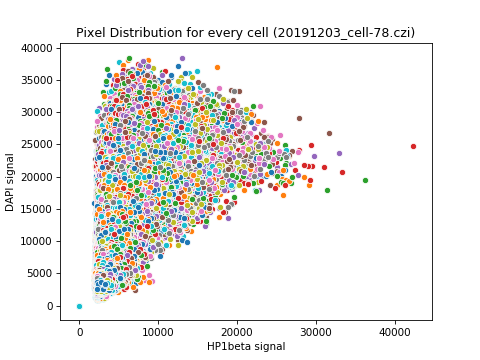

<IPython.core.display.Javascript object>


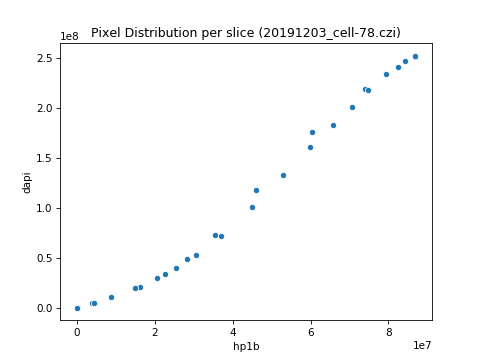

<IPython.core.display.Javascript object>


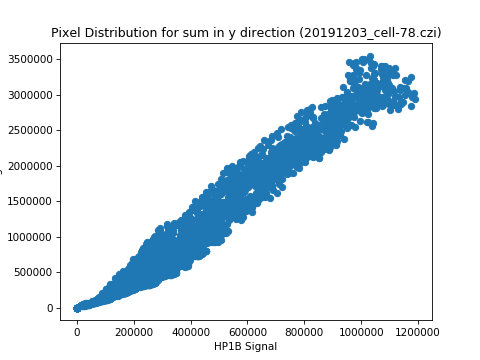

<IPython.core.display.Javascript object>


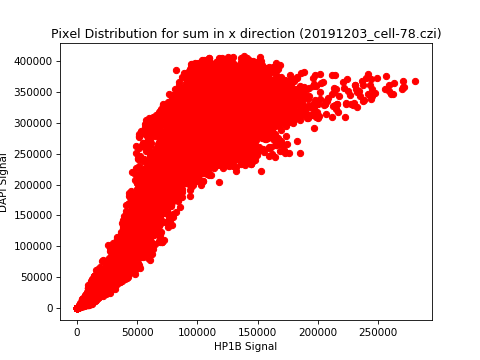

In [20]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #5

20191203_cell-64.czi
shape of the cell image:  (32, 3, 380, 380)
shape of nucleus mask:  (32, 380, 380)


<IPython.core.display.Javascript object>


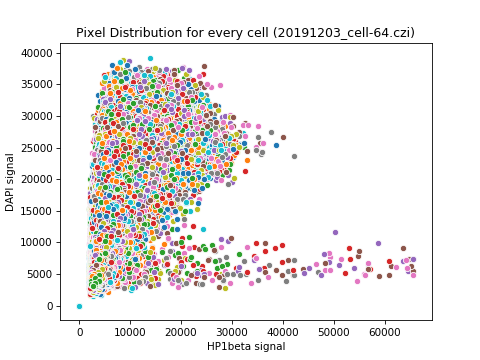

<IPython.core.display.Javascript object>


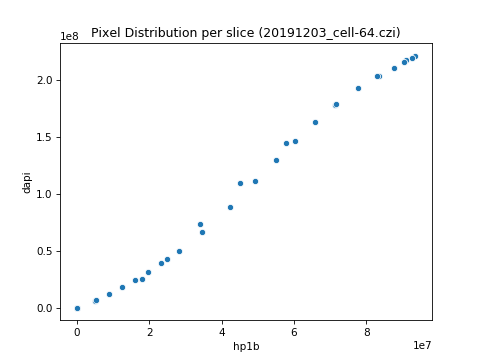

<IPython.core.display.Javascript object>


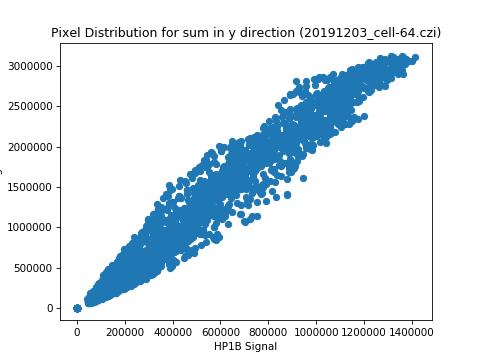

<IPython.core.display.Javascript object>


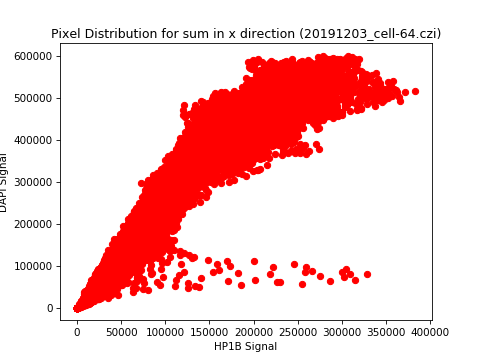

In [21]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #6

20191203_cell-87.czi
shape of the cell image:  (32, 3, 380, 380)
shape of nucleus mask:  (32, 380, 380)


<IPython.core.display.Javascript object>


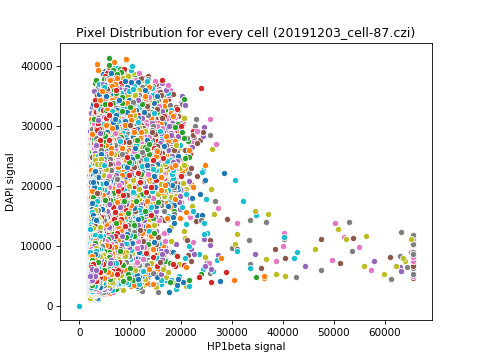

<IPython.core.display.Javascript object>


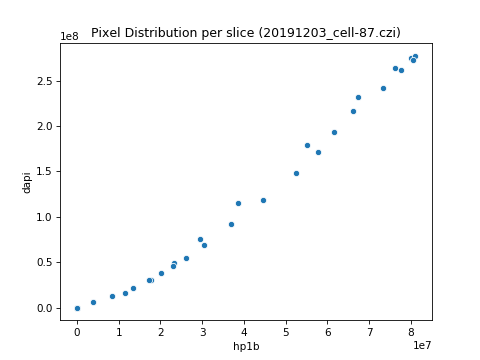

<IPython.core.display.Javascript object>


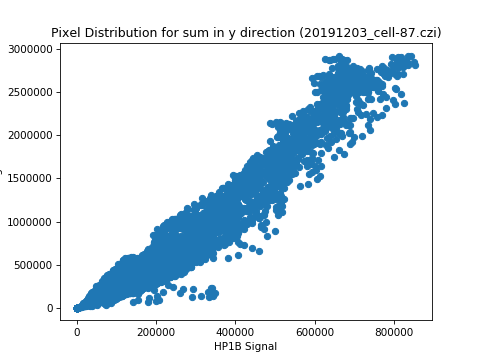

<IPython.core.display.Javascript object>


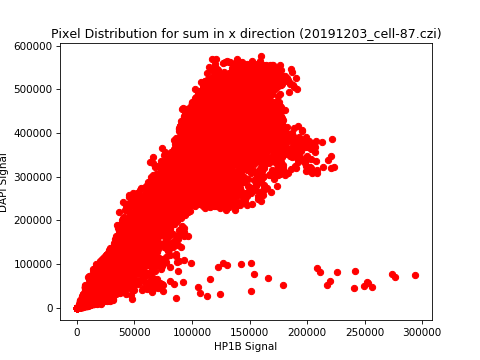

In [23]:
i=5
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #7

20191203_cell-103.czi
shape of the cell image:  (30, 3, 380, 380)
shape of nucleus mask:  (30, 380, 380)


<IPython.core.display.Javascript object>


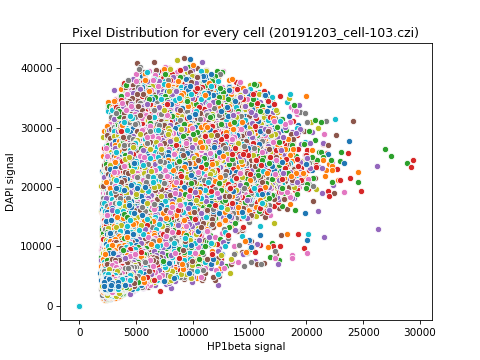

<IPython.core.display.Javascript object>


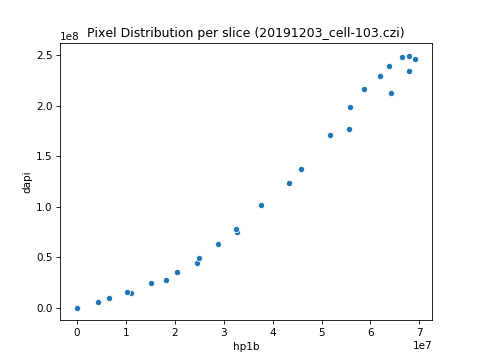

<IPython.core.display.Javascript object>


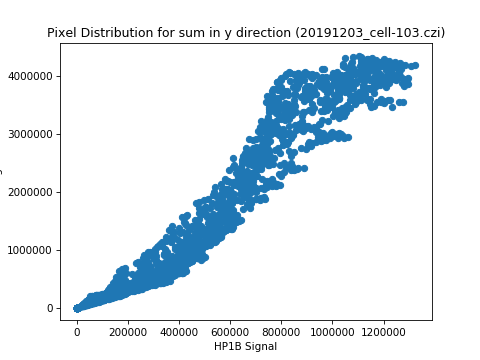

<IPython.core.display.Javascript object>


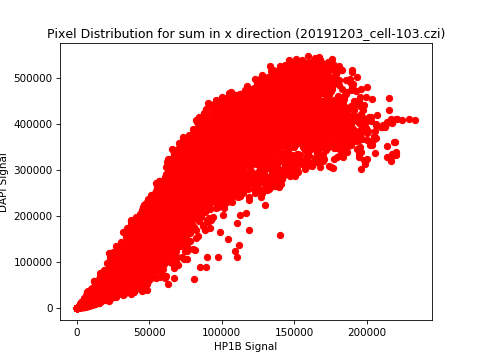

In [24]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #8

20191203_cell-80.czi
shape of the cell image:  (40, 3, 380, 380)
shape of nucleus mask:  (40, 380, 380)


<IPython.core.display.Javascript object>


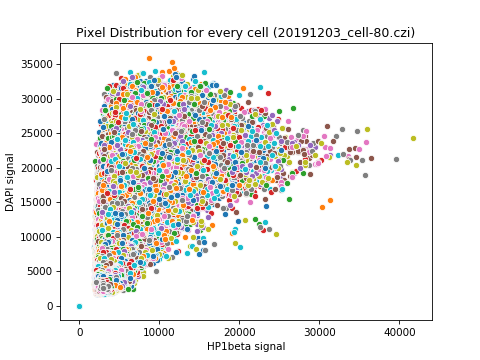

<IPython.core.display.Javascript object>


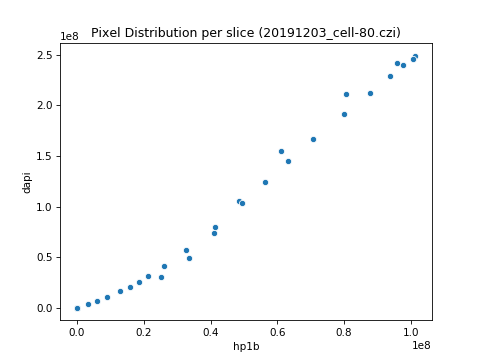

<IPython.core.display.Javascript object>


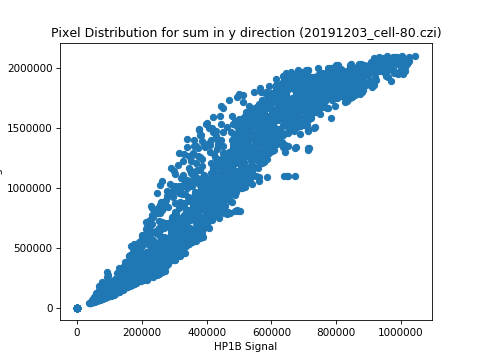

<IPython.core.display.Javascript object>


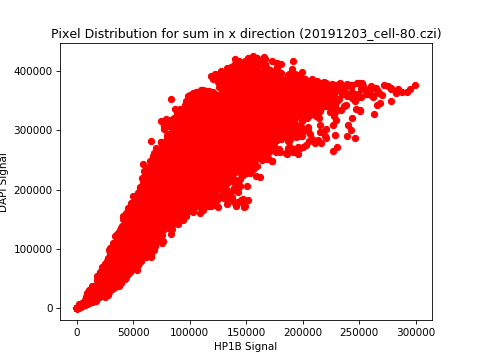

In [25]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #9

20191203_cell-123.czi
shape of the cell image:  (28, 3, 380, 380)
shape of nucleus mask:  (28, 380, 380)


<IPython.core.display.Javascript object>


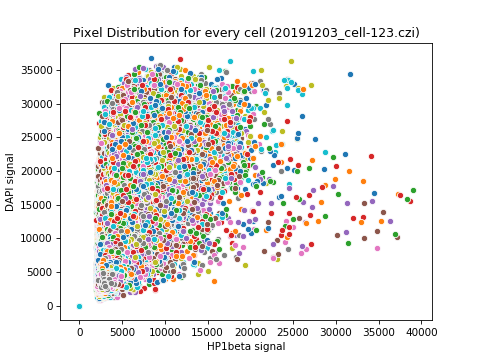

<IPython.core.display.Javascript object>


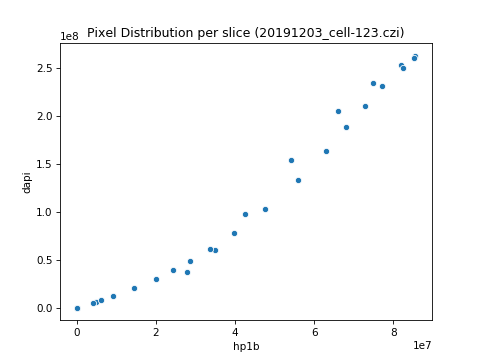

<IPython.core.display.Javascript object>


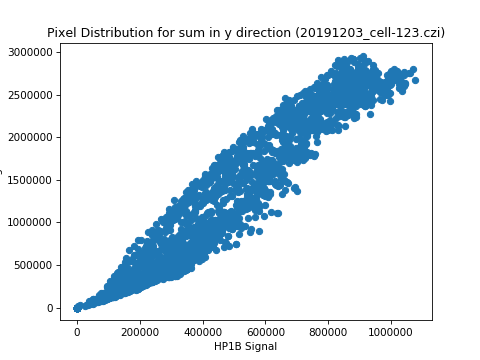

<IPython.core.display.Javascript object>


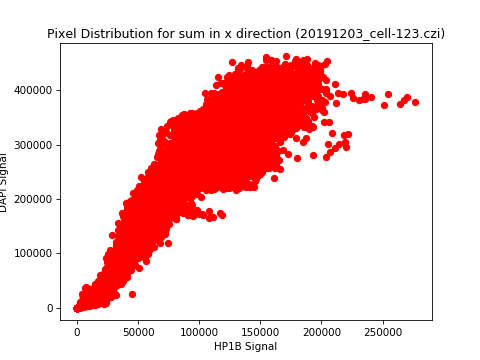

In [26]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #10

20191203_cell-05.czi
shape of the cell image:  (34, 3, 380, 380)
shape of nucleus mask:  (34, 380, 380)


<IPython.core.display.Javascript object>


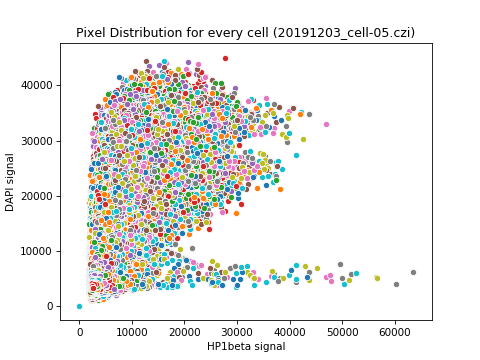

<IPython.core.display.Javascript object>


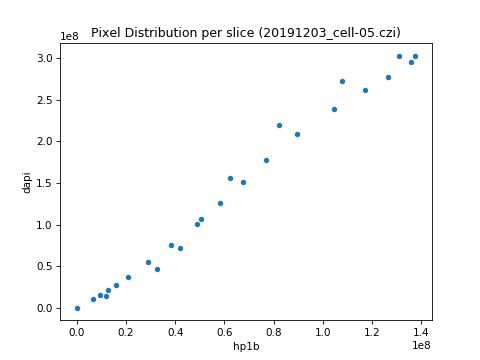

<IPython.core.display.Javascript object>


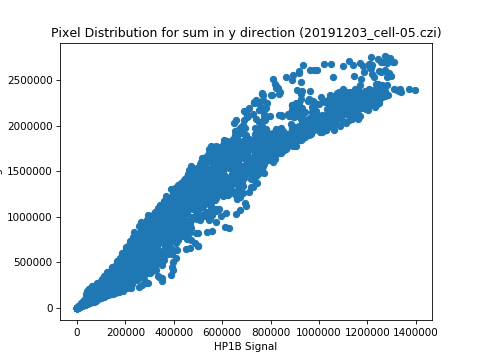

<IPython.core.display.Javascript object>


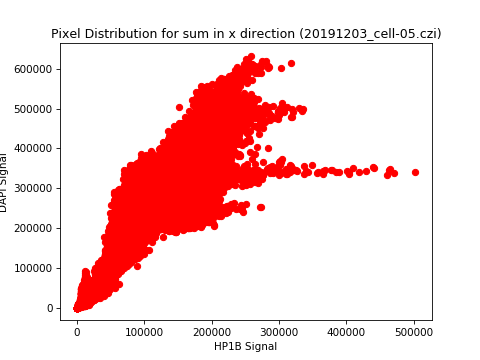

In [27]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

# inner part pixel distribution

## #1

20191203_cell-130.czi
shape of the cell image:  (29, 3, 380, 380)
shape of nucleus mask:  (29, 380, 380)


<IPython.core.display.Javascript object>


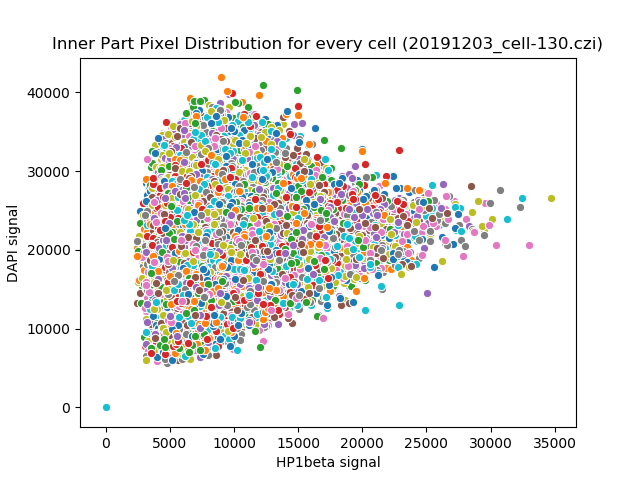

29 380 380
29 380 380


<IPython.core.display.Javascript object>


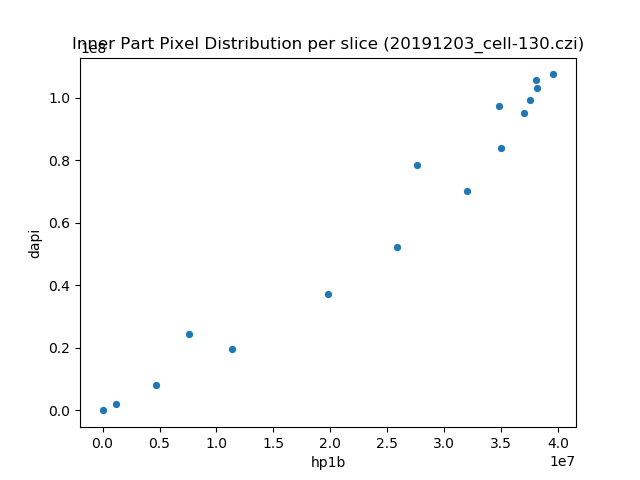

<IPython.core.display.Javascript object>


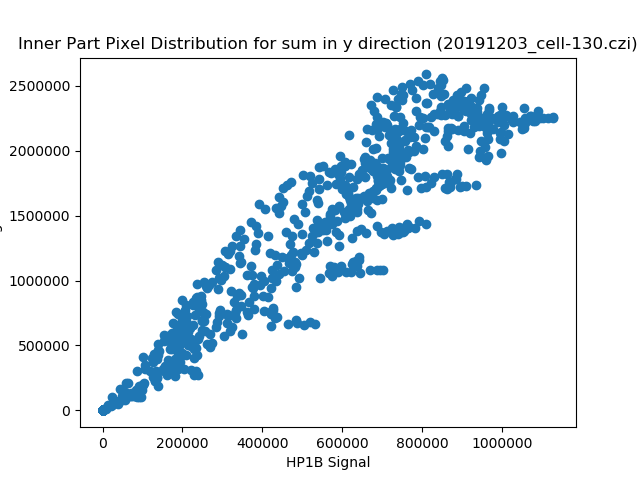

<IPython.core.display.Javascript object>


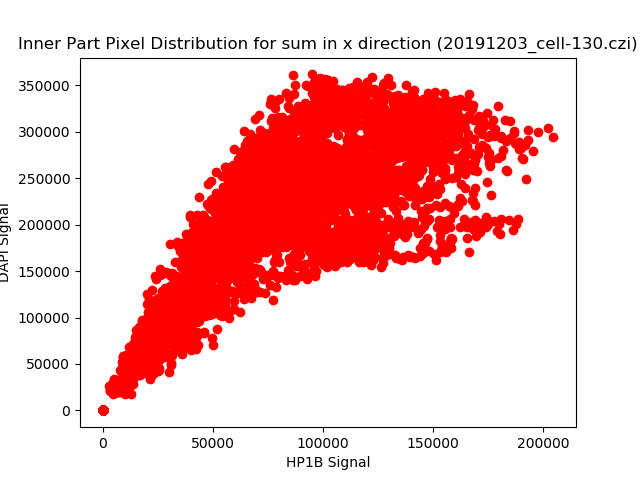

In [11]:
i=0
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
print(slides, xs, ys)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Inner Part Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)


slides, xs, ys = (hp1.shape)
print(slides, xs, ys)
figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Inner Part Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Inner Part Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Inner Part Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()



## #2

20191203_cell-03.czi
shape of the cell image:  (37, 3, 380, 380)
shape of nucleus mask:  (37, 380, 380)


<IPython.core.display.Javascript object>


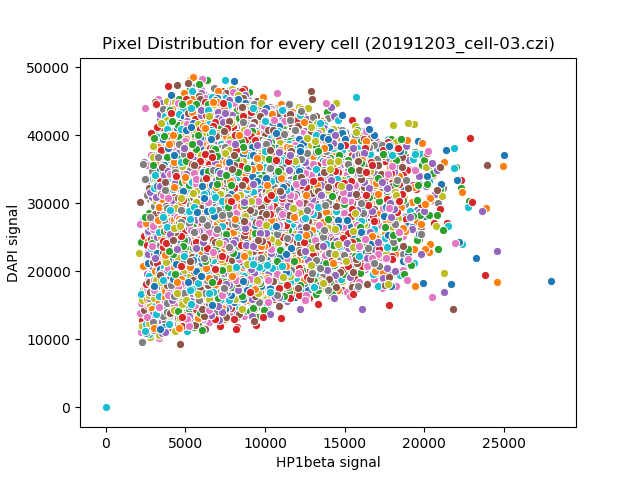

<IPython.core.display.Javascript object>


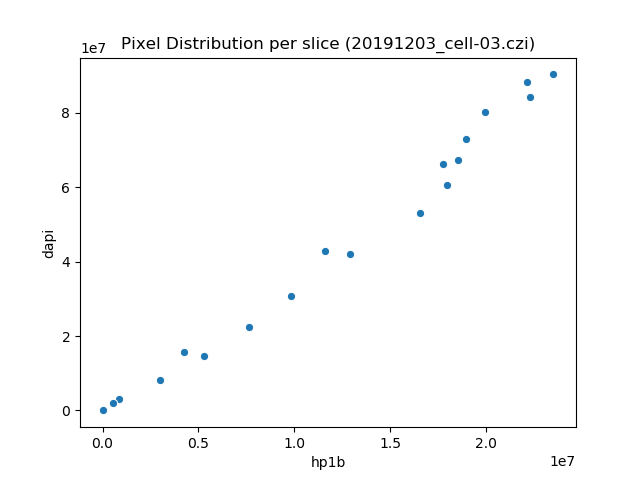

<IPython.core.display.Javascript object>


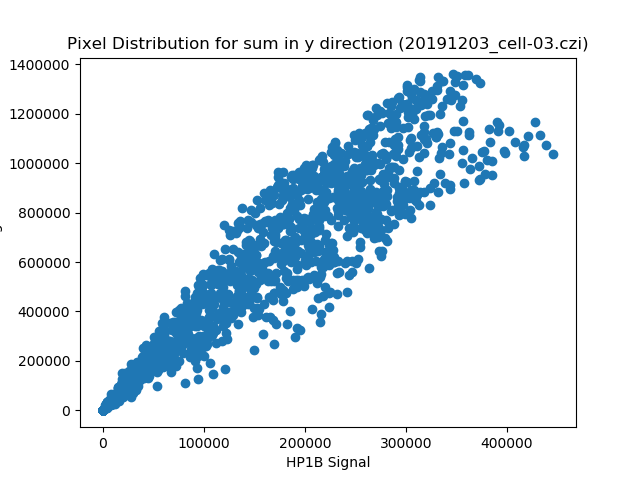

<IPython.core.display.Javascript object>


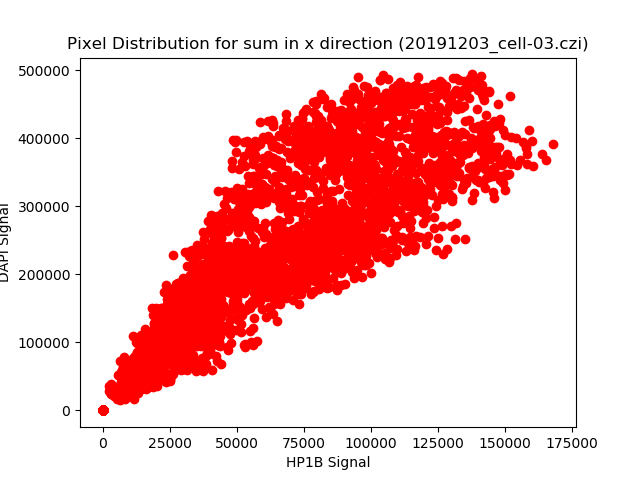

In [12]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #3

20191203_cell-137.czi
shape of the cell image:  (31, 3, 380, 380)
shape of nucleus mask:  (31, 380, 380)


<IPython.core.display.Javascript object>


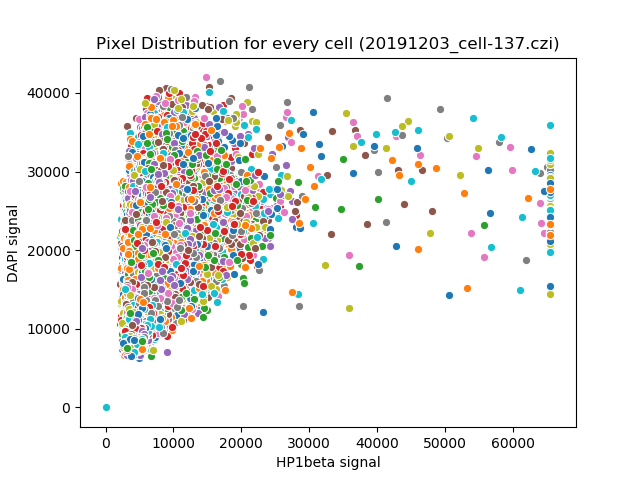

<IPython.core.display.Javascript object>


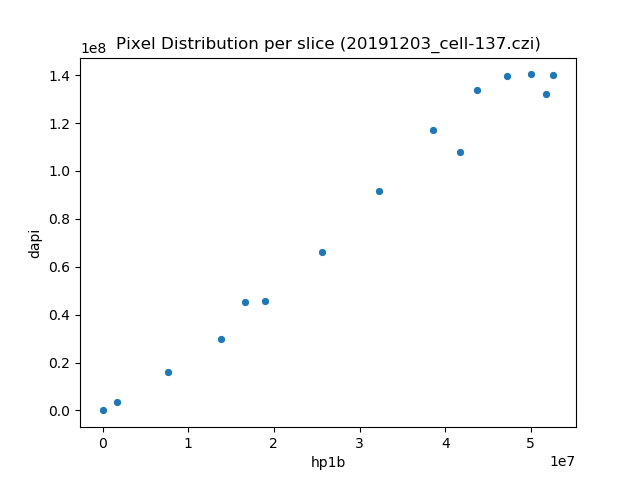

<IPython.core.display.Javascript object>


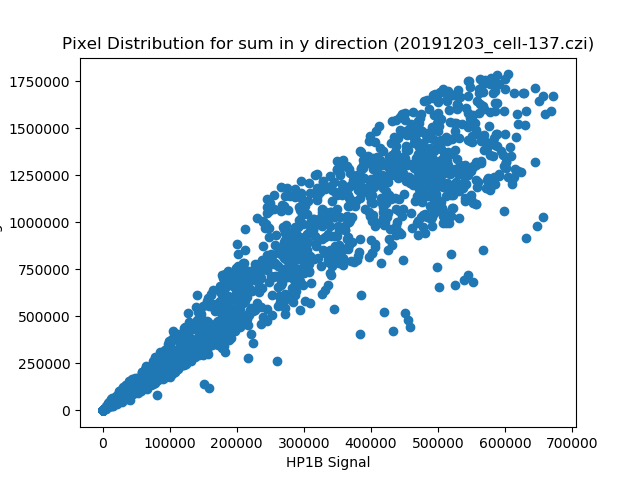

<IPython.core.display.Javascript object>


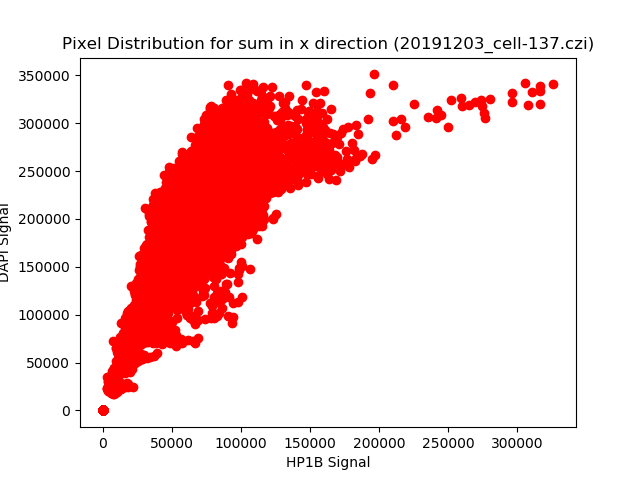

In [13]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #4

20191203_cell-78.czi
shape of the cell image:  (34, 3, 380, 380)
shape of nucleus mask:  (34, 380, 380)


<IPython.core.display.Javascript object>


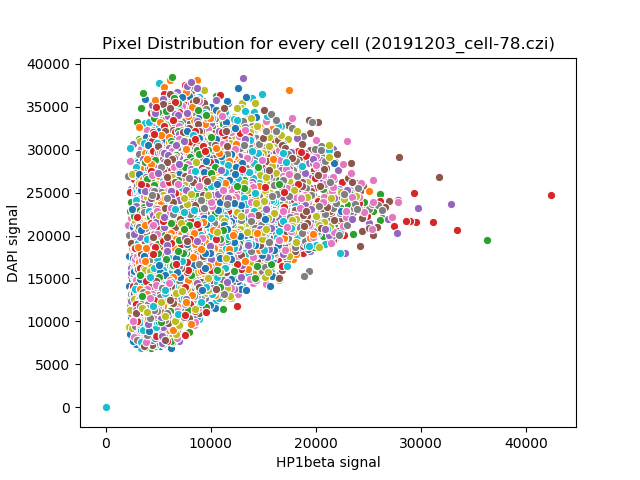

<IPython.core.display.Javascript object>


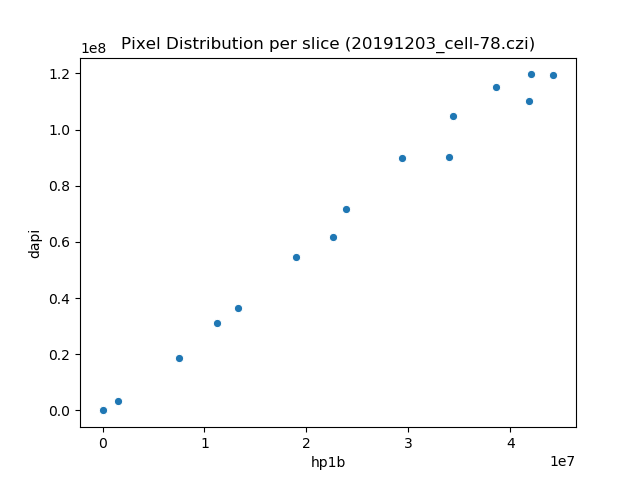

<IPython.core.display.Javascript object>


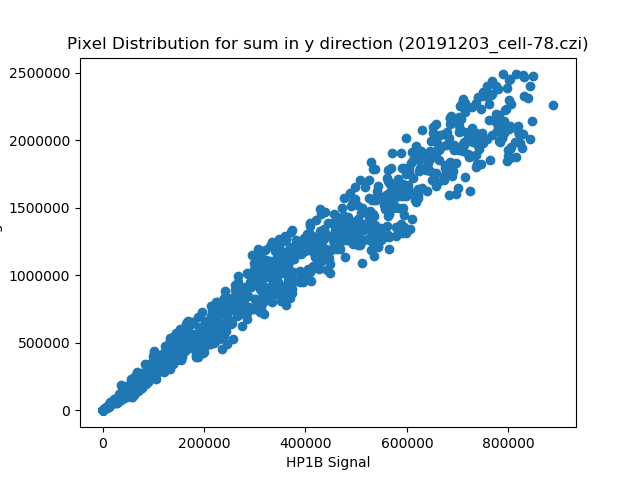

<IPython.core.display.Javascript object>


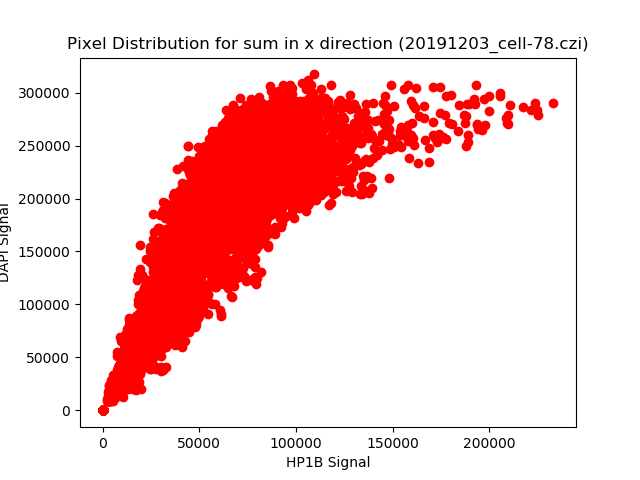

In [14]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #5

20191203_cell-64.czi
shape of the cell image:  (32, 3, 380, 380)
shape of nucleus mask:  (32, 380, 380)


<IPython.core.display.Javascript object>


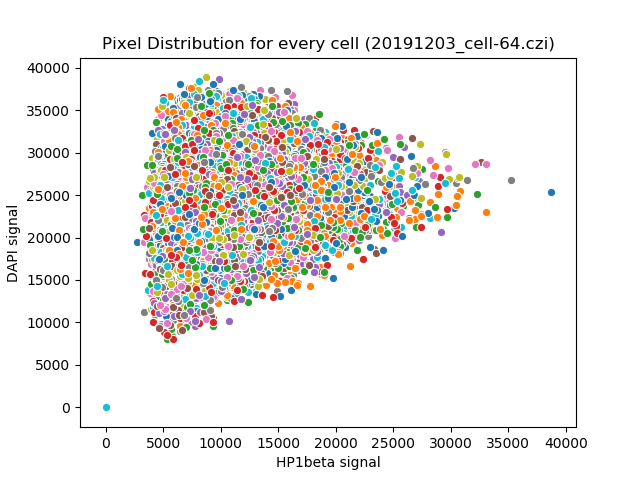

<IPython.core.display.Javascript object>


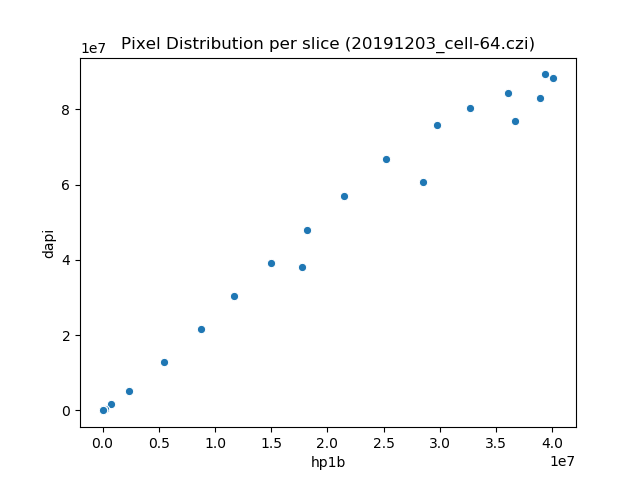

<IPython.core.display.Javascript object>


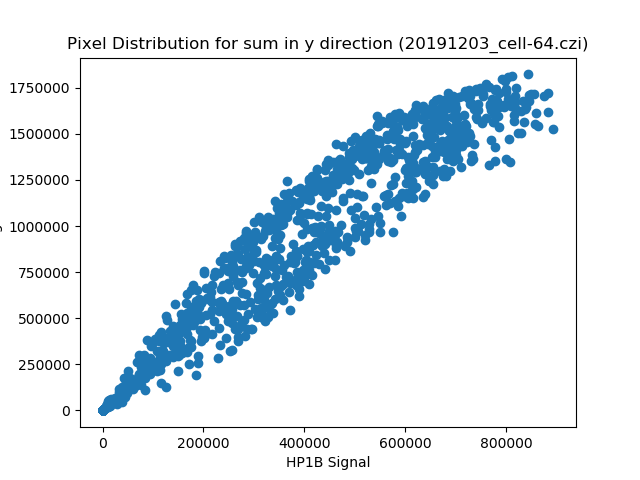

<IPython.core.display.Javascript object>


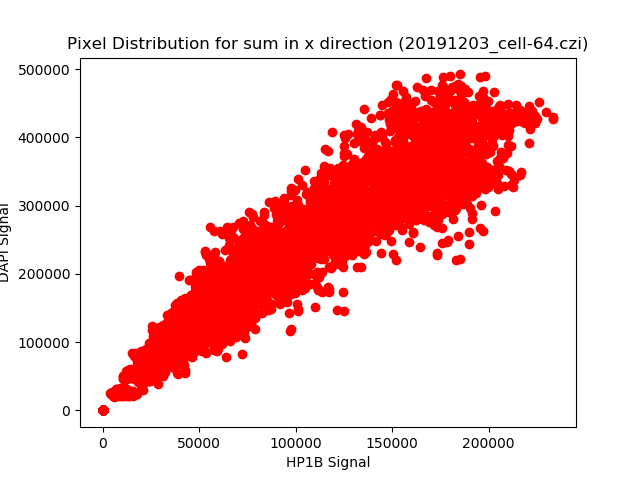

In [15]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #6

20191203_cell-87.czi
shape of the cell image:  (32, 3, 380, 380)
shape of nucleus mask:  (32, 380, 380)


<IPython.core.display.Javascript object>


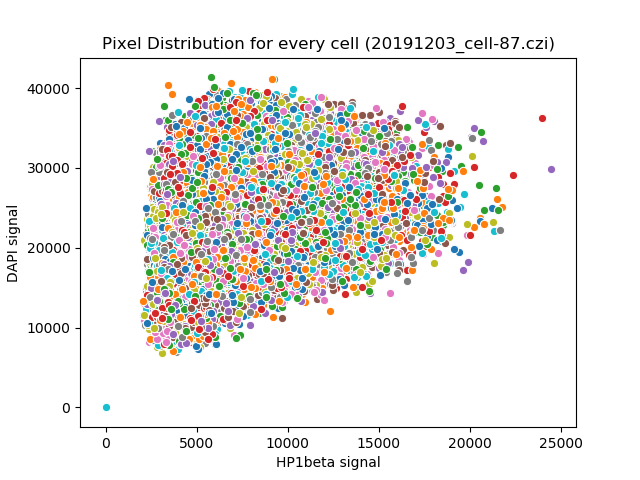

<IPython.core.display.Javascript object>


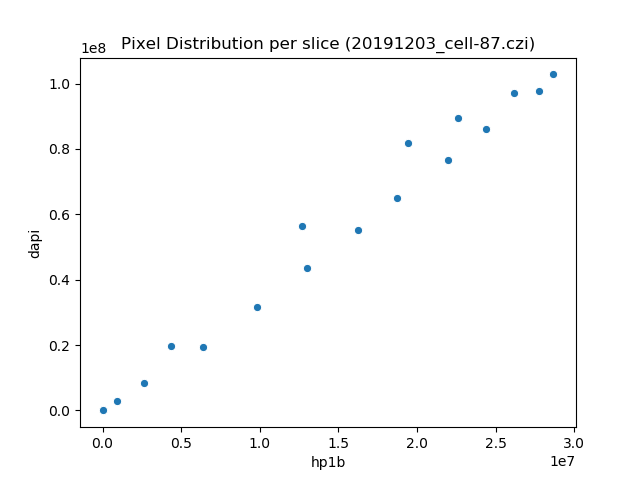

<IPython.core.display.Javascript object>


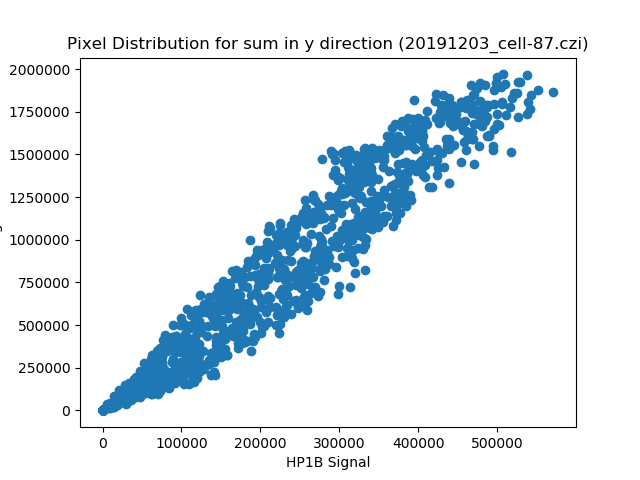

<IPython.core.display.Javascript object>


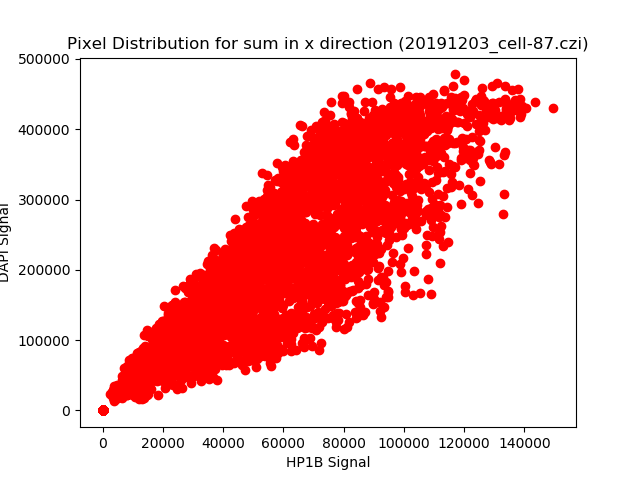

In [16]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #7

20191203_cell-103.czi
shape of the cell image:  (30, 3, 380, 380)
shape of nucleus mask:  (30, 380, 380)


<IPython.core.display.Javascript object>


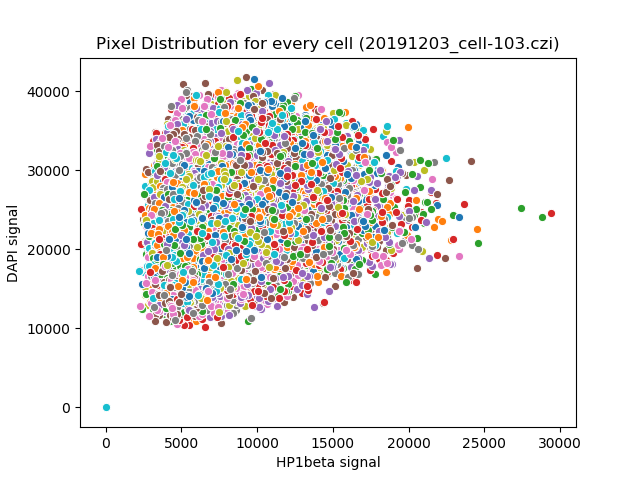

<IPython.core.display.Javascript object>


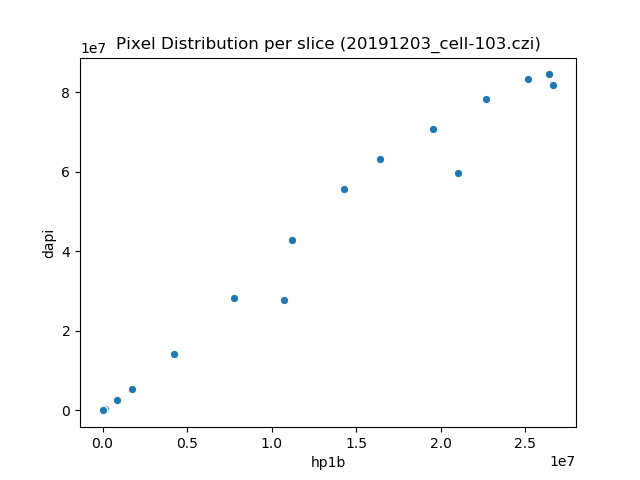

<IPython.core.display.Javascript object>


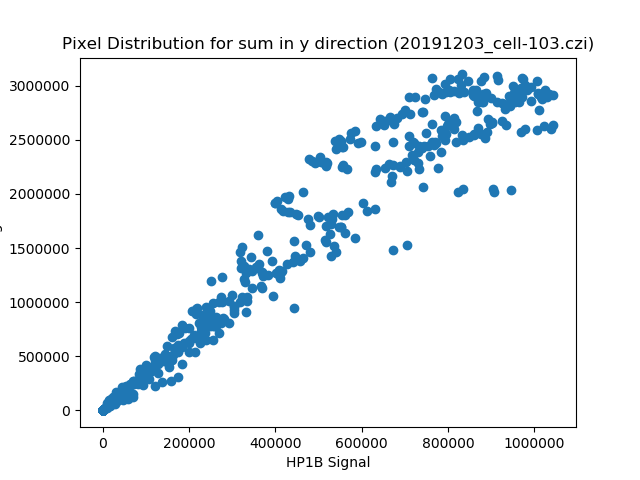

<IPython.core.display.Javascript object>


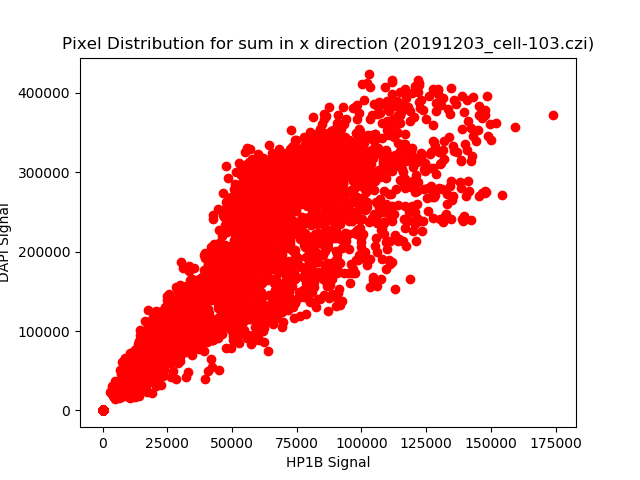

In [17]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #8

20191203_cell-80.czi
shape of the cell image:  (40, 3, 380, 380)
shape of nucleus mask:  (40, 380, 380)


<IPython.core.display.Javascript object>


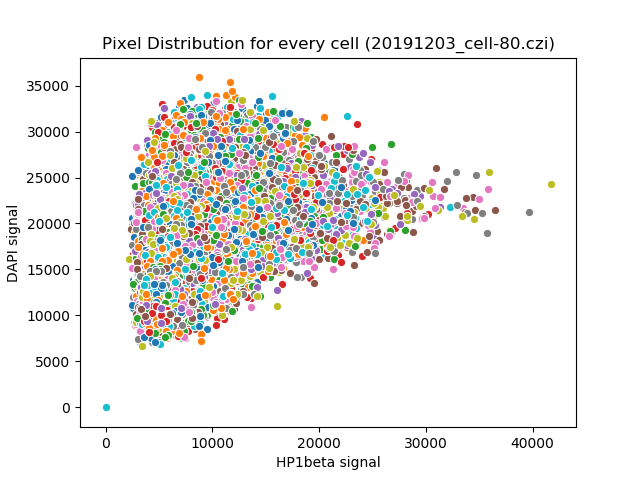

<IPython.core.display.Javascript object>


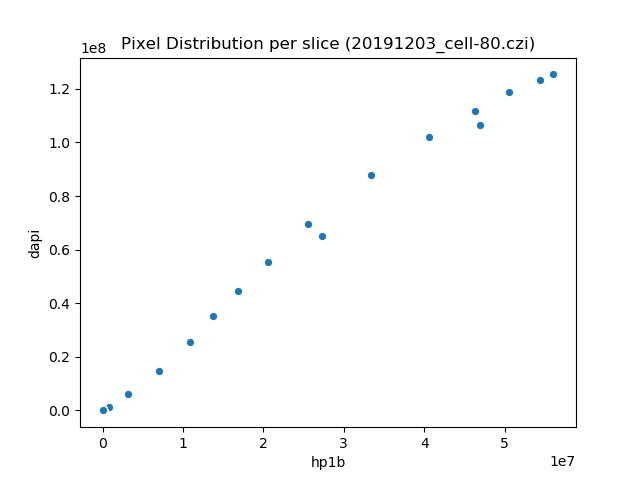

<IPython.core.display.Javascript object>


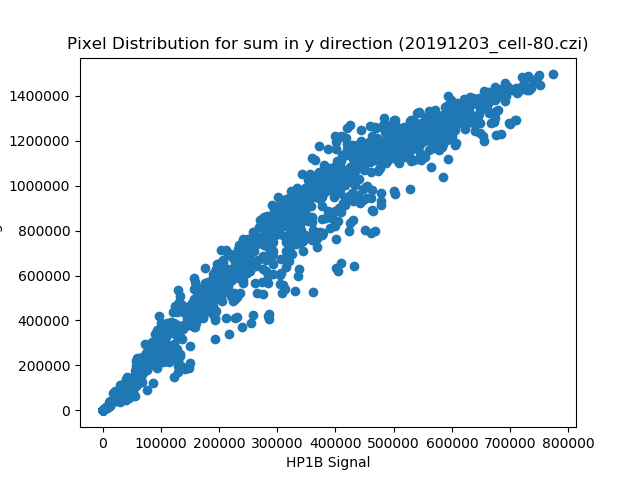

<IPython.core.display.Javascript object>


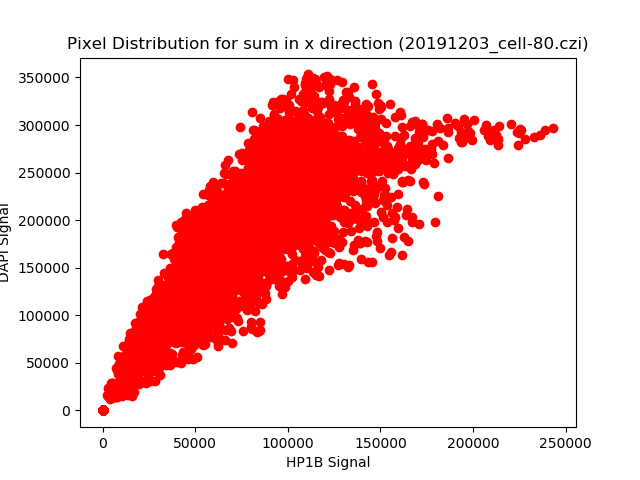

In [18]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #9

20191203_cell-123.czi
shape of the cell image:  (28, 3, 380, 380)
shape of nucleus mask:  (28, 380, 380)


<IPython.core.display.Javascript object>


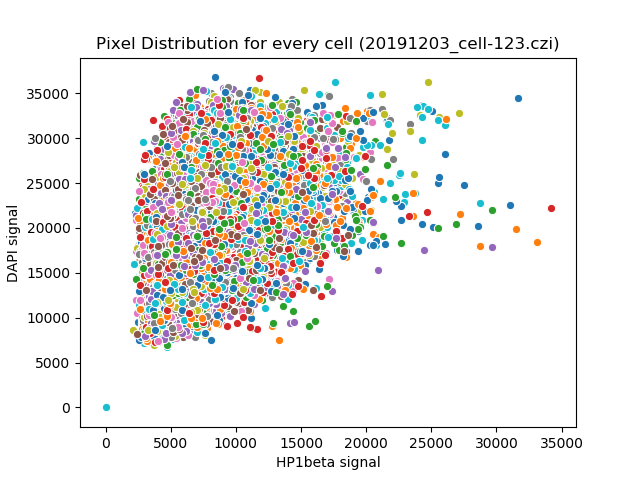

<IPython.core.display.Javascript object>


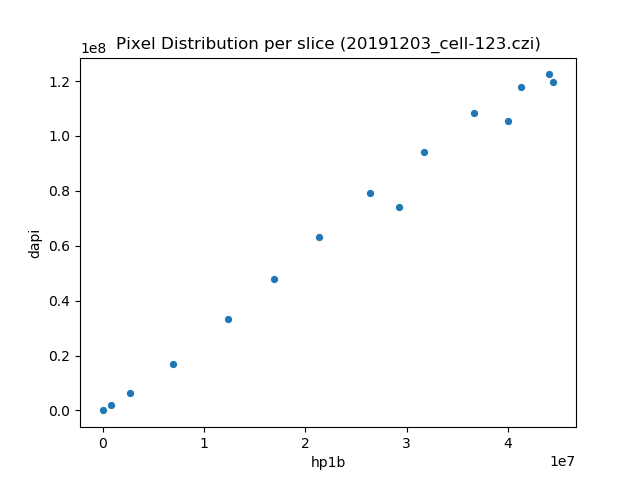

<IPython.core.display.Javascript object>


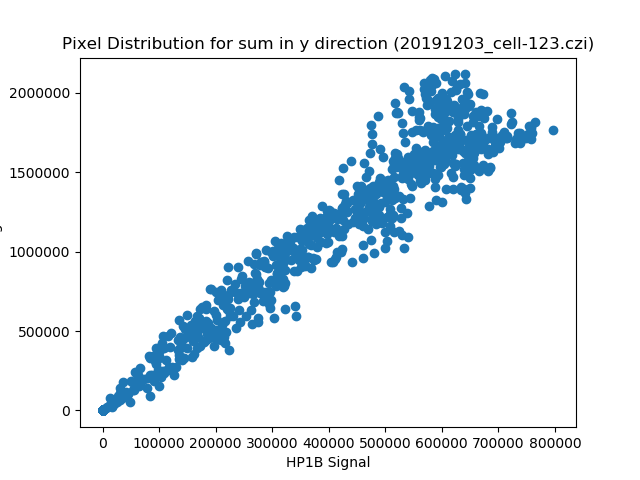

<IPython.core.display.Javascript object>


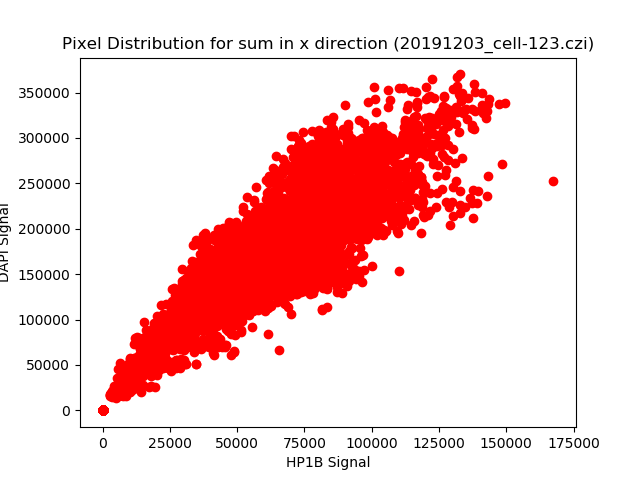

In [19]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()

## #10

20191203_cell-05.czi
shape of the cell image:  (34, 3, 380, 380)
shape of nucleus mask:  (34, 380, 380)


<IPython.core.display.Javascript object>


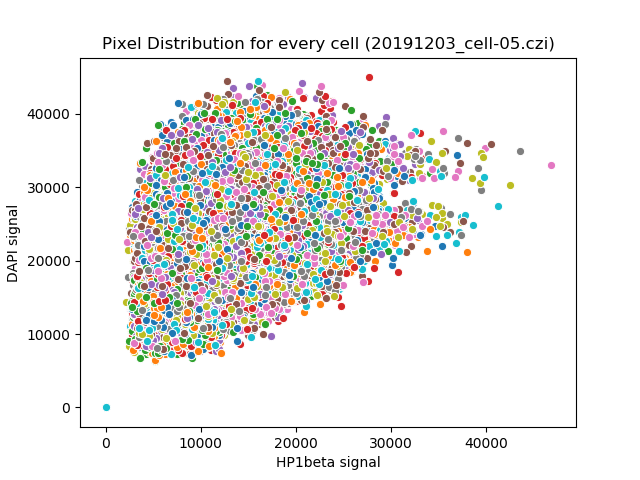

<IPython.core.display.Javascript object>


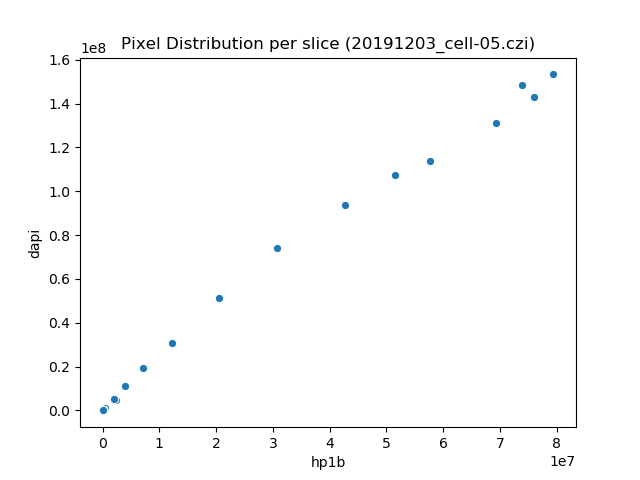

<IPython.core.display.Javascript object>


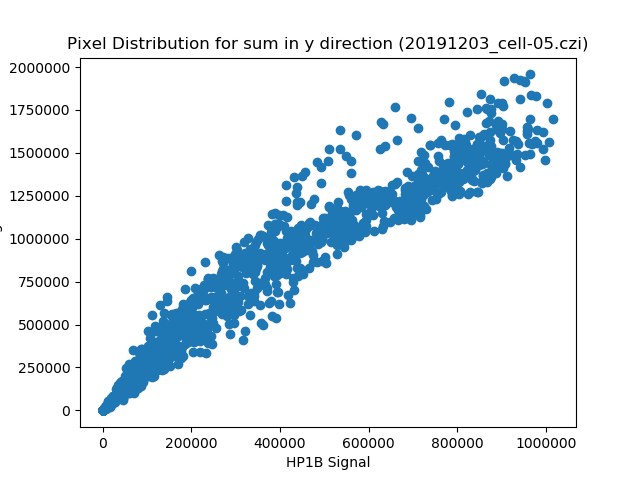

<IPython.core.display.Javascript object>


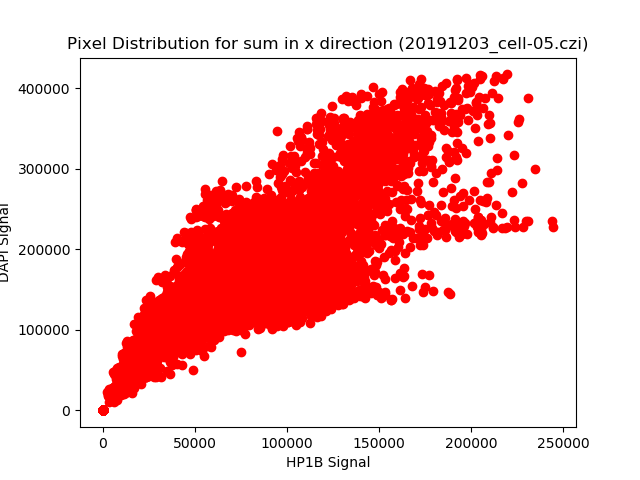

In [20]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','erosion_nuc_mask'))
nucPath=nucPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


figA=plt.figure(1)
slides, xs, ys = (hp1.shape)
for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=hp1[slide,x,:],y=dapi[slide,x,:])
        plt.ylabel('DAPI signal')
        plt.xlabel('HP1beta signal')
        plt.title(f'Pixel Distribution for every cell ({mycell.file})')
    figA.show()

## per slice
df=pd.DataFrame(columns=['hp1b','dapi'])
df['hp1b']=hp1.sum(-1).sum(-1)
df['dapi']=dapi.sum(-1).sum(-1)



figB=plt.figure(2)
sns.scatterplot(x='hp1b',y='dapi',data=df)
plt.title(f'Pixel Distribution per slice ({mycell.file})')
figB.show()


## for sum in y direction
figC=plt.figure(3)
plt.scatter(x=hp1.sum(-1),y=dapi.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in y direction ({mycell.file})')
figC.show()

## for sum in x direction
figD=plt.figure(4)
plt.scatter(x=hp1.sum(0),y=dapi.sum(0),color='red')
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title(f'Pixel Distribution for sum in x direction ({mycell.file})')
figD.show()